In [1]:
#imports
import csv
import re
import os
import pandas as pd
import numpy as np
import nltk

#for tweet tokenization
from nltk import TweetTokenizer
tt = TweetTokenizer()

from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
pstem = PorterStemmer()
lem = WordNetLemmatizer()


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

from pprint import pprint
from datetime import datetime

#plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline


#word count
from collections import Counter


#sentiment analysis
from textblob import TextBlob

# spacy for lemmatization
import spacy;
import en_core_web_sm

# Topic modeling
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#escaping html characters
from html.parser import HTMLParser
html_parser = HTMLParser()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sherinnaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sherinnaha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sherinnaha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sherinnaha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/sherinnaha/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
#loading the file and converting to a dataframe
wm_final = pd.read_csv('../CSV/ms_tweets_final.csv')

wm_final=wm_final.drop('Unnamed: 0',axis=1)
wm_final.shape

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,4,12,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(50629, 21)

In [3]:
#dropping duplicates
wm_final = wm_final.drop_duplicates(subset = 'text', keep = 'first').reset_index(drop = True)
wm_final.head()

,screen_name,username,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,text,text_html,links,...,has_media,img_urls,video_url,likes,retweets,replies,is_replied,is_reply_to,parent_tweet_id,reply_to_users
0,hapeit,Hugh Perry,51955491,1247671808616280067,/hapeit/status/1247671808616280067,2020-04-07 23:45:14,1586303114,The 15 Best Investing Books of All Time | Weal...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.wealthmanagement.com/people/poll...,...,False,[],NaN,2.0,1.0,0.0,False,False,NaN,[]
1,TheChestnutPost,The Chestnut Post,880112324987822082,1247671082288590850,/TheChestnutPost/status/1247671082288590850,2020-04-07 23:42:21,1586302941,Opus Wealth Management Group with $350 Million...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.thechestnutpost.com/news/opus-we...,...,False,[],NaN,0.0,0.0,0.0,False,False,NaN,[]
2,BBQHog7000,BBQ Hog 7000,1862195880,1247670786774745089,/BBQHog7000/status/1247670786774745089,2020-04-07 23:41:10,1586302870,Chatham Wealth Management Partners with Local ...,"<p class=""TweetTextSize js-tweet-text tweet-te...","['http://TAPinto.net', 'https://ift.tt/3e3lDuq']",...,False,[],NaN,0.0,0.0,0.0,False,False,NaN,[]
3,IAM__Network,IAM Platform,226310002,1247668718043385857,/IAM__Network/status/1247668718043385857,2020-04-07 23:32:57,1586302377,FN’s Trading and Tech Awards 2020: The nominee...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://blog.iammarketingmedia.com/fns-tradi...,...,True,['https://pbs.twimg.com/media/EVCcFkgWAAEyx8S....,NaN,1.0,0.0,0.0,False,False,NaN,[]
4,DuisThrivent,Connor Duis,1179406874275438593,1247667977899495424,/DuisThrivent/status/1247667977899495424,2020-04-07 23:30:01,1586302201,"67: If you were born after 1959, this is your ...","<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,True,['https://pbs.twimg.com/media/EVCbahYU4AMz47z....,NaN,0.0,0.0,0.0,False,False,NaN,[]


In [4]:
((50629 - 45488)/50629)*100
#~10% tweets are duplicated

10.154259416539928

# Data Cleaning
This does not include Stemming, Lemmatization, Tokenization or Stop Words Removal

In [5]:
#convert to lower case
wm_final['text'] = wm_final['text'].str.lower()
wm_final.head()['text']

0    the 15 best investing books of all time | weal...
1    opus wealth management group with $350 million...
2    chatham wealth management partners with local ...
3    fn’s trading and tech awards 2020: the nominee...
4    67: if you were born after 1959, this is your ...
Name: text, dtype: object

In [6]:
#Allocating a separate Dataframe for the tweet text
tweets = wm_final[["text"]]
tweets.head()
tweets['text'].head()
tweets.shape

(45488, 1)

In [7]:
# get rid of all kinds of strange symbols from text
def preprocess(Text):
    #Text = Text.str.decode('utf-8')
    Text = Text.str.replace("(<br/>)", "")
    Text = Text.str.replace('(<a).*(>).*(</a>)', '')
    Text = Text.str.replace('(&amp)', '')
    Text = Text.str.replace('(&gt)', '')
    Text = Text.str.replace('(&lt)', '')
    Text = Text.str.replace('(\xa0…)', ' ')  
    Text = Text.str.replace('(\u2066)', ' ')
    Text = Text.str.replace('(\u2069)', ' ')
    Text = Text.str.replace('(\n)', ' ')
    Text = Text.str.replace('+', '')
    
    #removing twitter images URL
    Text = Text.str.replace('pic.twitter.com', '')
    return Text

#apply all the preprocess functions
tweets['text'] = preprocess(tweets.text)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#Removing urls
tweets = tweets.replace('https?:\/\/.*[\r\n]*', '', regex = True)


#removing hashtags(including the word after #), numbers and twitter handles
#removing random symbols after /
tweets = tweets.replace("[0-9]+", '', regex = True)
tweets = tweets.replace("#[a-zA-Z0-9]+", '', regex = True)
tweets = tweets.replace("@[a-zA-Z0-9]+", '', regex = True)
tweets = tweets.replace("/[a-zA-Z0-9]+", '', regex = True)
tweets['text'][0]

'the  best investing books of all time | wealth management  _mgmt '

In [9]:
tweets = tweets.replace("[,@!&\;|'-?\.$%_]",'', regex = True)
tweets['text'][0]

'the  best investing books of all time  wealth management  mgmt '

In [10]:
tweets = tweets.replace("[\\u2018\\u2019]", "'", regex = True)

In [11]:
# remove whitespace and punctuations
rm_punc = re.compile(r"(\W)")
rm_space = re.compile(r"(\s+)")
tweets.text = tweets.text.apply(lambda x: rm_punc.sub(' ', x))
tweets.text = tweets.text.apply(lambda x: rm_space.sub(' ', x))
tweets['text'][0]

'the best investing books of all time wealth management mgmt '

In [12]:
#Escaping HTML Characters
tweets.text.apply(lambda x: html_parser.unescape(x))

#Setting to ASCII encoding
tweets.text.apply(lambda x: x.encode('ascii','ignore'))
tweets.text=tweets.text.astype(str)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  


In [13]:
tweets['text'][10]

'here is a look at the bestperforming stocks off the virus low as of tuesday '

In [14]:
#dealing with contracted words
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
  contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
  def expand_match(contraction):
    match = contraction.group(0)
    first_char = match[0]
    expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
    expanded_contraction = first_char+expanded_contraction[1:]
    return expanded_contraction
        
  expanded_text = contractions_pattern.sub(expand_match, text)
  expanded_text = re.sub("'", "", expanded_text)
  return expanded_text


In [15]:
def normalize_corpus(corpus):
  normalized_corpus = []
  
  for doc in corpus:
    doc = expand_contractions(doc)
    normalized_corpus.append(doc)

  return normalized_corpus

tweets['cleaned'] = pd.Series(normalize_corpus(tweets['text']))

In [18]:
#Extracting date and time
#extracting date and time
tweets['timestamp']= wm_final['timestamp']
tweets['date'] = pd.to_datetime(tweets['timestamp'], errors='coerce').dt.strftime('%Y-%m-%d')
tweets['time'] = pd.to_datetime(tweets['timestamp'], errors='coerce').dt.strftime("%H-%M-%S")


#adding retweets and #likes and replies
tweets['retweets']=wm_final['retweets']
tweets['likes']=wm_final['likes']
tweets['replies']=wm_final['replies']
tweets['username']=wm_final['username']

tweets.head()

,text,cleaned,timestamp,date,time,retweets,likes,replies,username
0,the best investing books of all time wealth ma...,the best investing books of all time wealth ma...,2020-04-07 23:45:14,2020-04-07,23-45-14,1.0,2.0,0.0,Hugh Perry
1,opus wealth management group with million in a...,opus wealth management group with million in a...,2020-04-07 23:42:21,2020-04-07,23-42-21,0.0,0.0,0.0,The Chestnut Post
2,chatham wealth management partners with local ...,chatham wealth management partners with local ...,2020-04-07 23:41:10,2020-04-07,23-41-10,0.0,0.0,0.0,BBQ Hog 7000
3,fn s trading and tech awards the nominees read...,fn s trading and tech awards the nominees read...,2020-04-07 23:32:57,2020-04-07,23-32-57,0.0,1.0,0.0,IAM Platform
4,if you were born after this is your full reti...,if you were born after this is your full reti...,2020-04-07 23:30:01,2020-04-07,23-30-01,0.0,0.0,0.0,Connor Duis


# Sentiment Labelling

In [111]:
tweets_copy1= tweets.copy()
# get the polarity of each text
tweets_copy1['polarity'] = tweets_copy1.text.map(lambda text: TextBlob(text).sentiment.polarity)
tweets_copy1['subjectivity'] = tweets_copy1.text.map(lambda text: TextBlob(text).sentiment.subjectivity)
# classify sentiment into positive and negative ones
tweets_copy1['sentiment'] = ''
tweets_copy1['sentiment'][tweets_copy1['polarity'] > 0] = 'positive'
tweets_copy1['sentiment'][tweets_copy1['polarity'] == 0] = 'neutral'
tweets_copy1['sentiment'][tweets_copy1['polarity'] < 0] = 'negative'

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


# Key Word Analysis

In [129]:
#update this list with keywords
#keywords = ['artificial intelligence','ai','digital', 'robo', 'roboadvisors', 'robo advisor','roboadvisor', 'chatbots','chatbot']

#keywords = ['asia','china','asian','chinese', 'asian private']
keywords = ['sustainable']

df1=tweets_copy1[tweets_copy1.text.apply(lambda x: any(substring in x for substring in keywords))]

In [131]:
#df1.shape
df1.to_csv('sustainable.csv')

In [97]:
avg_polarity = list()
num_texts = list()

for word in keywords:
    avg_polarity.append(tweets_copy1[tweets_copy1['text'].str.match(word)]['polarity'].mean())
    num_texts.append(len(tweets_copy1[tweets_copy1['text'].str.match(word)]))

In [42]:
word_analysis = pd.DataFrame()
word_analysis['keywords'] = keywords
word_analysis['avg_polarity'] = avg_polarity
word_analysis['num_texts'] = num_texts

word_analysis= word_analysis.sort_values(by = ['avg_polarity'],ascending = True)
word_analysis.reset_index(inplace = True)
word_analysis.drop('index',axis = 1,inplace = True)


In [43]:
word_analysis

,keywords,avg_polarity,num_texts
0,artificial intelligence,-0.430394,20
1,roboadvisors,0.023810,7
2,robo,0.041973,39
3,digital,0.047348,97
4,roboadvisor,0.049383,15
5,robo advisor,0.053081,15
6,ai,0.076325,45
7,chatbots,NaN,0
8,chatbot,NaN,0


In [44]:
positive = word_analysis[word_analysis['avg_polarity']>0.2].index
mild = word_analysis[(word_analysis['avg_polarity']>=0) &(word_analysis['avg_polarity']<=0.2)].index
negative= word_analysis[word_analysis['avg_polarity']<0].index

Text(0.5, 1.0, 'The average polarity of all Tweets containing a keyword')

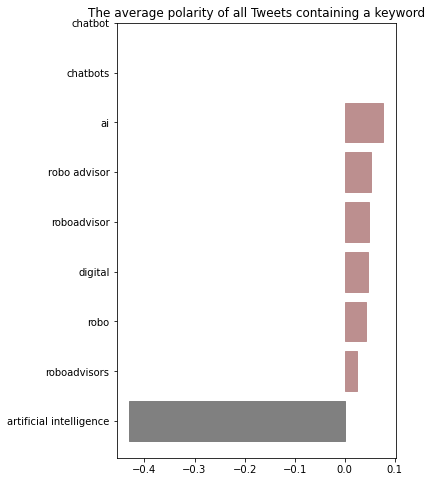

In [45]:
fig, ax = plt.subplots(figsize=(5,8))
barlist =plt.barh(range(len(word_analysis['avg_polarity'])), word_analysis['avg_polarity'],color = 'grey')
ax.set_yticks(range(len(word_analysis['avg_polarity'])))
ax.set_yticklabels(word_analysis['keywords'])
plt.rc('xtick', labelsize=10) 
for word in positive:
    barlist[word].set_color('lightcoral')
for word in mild:
    barlist[word].set_color('rosybrown')
for word in negative:
    barlist[word].set_color('grey')
plt.title('The average polarity of all Tweets containing a keyword')

In [52]:
tweets_kw=tweets_copy1[tweets_copy1.text.apply(lambda x: any(substring in x for substring in keywords))]

In [55]:
tweets_kw.head()

,text,cleaned,timestamp,date,time,retweets,likes,replies,username,polarity,sentiment
16,artificial intelligence startups ask dominic c...,artificial intelligence startups ask dominic c...,2020-04-07 21:32:57,2020-04-07,21-32-57,1.0,1.0,0.0,IAM Platform,-0.033333,negative
24,indiana trust wealth management salutes the un...,indiana trust wealth management salutes the un...,2020-04-07 21:06:44,2020-04-07,21-06-44,0.0,2.0,0.0,Indiana Trust Wealth Management,0.000000,neutral
50,according to neil patel an expert in digital m...,according to neil patel an expert in digital m...,2020-04-07 19:12:24,2020-04-07,19-12-24,0.0,0.0,0.0,Kevin M. Dumont,0.144444,positive
53,the next frontier of artificial intelligence p...,the next frontier of artificial intelligence p...,2020-04-07 19:04:40,2020-04-07,19-04-40,0.0,0.0,0.0,IAM Platform,-0.025000,negative
56,icymi spend lunch learning how to financially ...,icymi spend lunch learning how to financially ...,2020-04-07 18:55:06,2020-04-07,18-55-06,0.0,1.0,0.0,Gael Alumni,0.000000,neutral


# Topic Modelling

In [56]:
tweets_copy2 = tweets_kw.copy()

In [58]:
#remove stop words
stop_words = stopwords.words('english')
stop_words[0:5]

not_stopwords = ['not']
common_words =['please',
               'the','would','could','can','may','must', 'should'
              # 'us','i','you','this','we','me','that','it',
               'de','s','pic','t','m','en','la','que','don','re','e','el','ca', 'wealth', 'management']
stop_words.extend(word for word in common_words if word not in stop_words)
final_stop_words = set([word for word in stop_words if word not in not_stopwords])
tweets_copy2.cleaned = tweets_copy2.cleaned.apply(lambda x: ' '.join([word for word in x.split() if word not in final_stop_words]))
    
tweets_copy2.head(20)

,text,cleaned,timestamp,date,time,retweets,likes,replies,username,polarity,sentiment
16,artificial intelligence startups ask dominic c...,artificial intelligence startups ask dominic c...,2020-04-07 21:32:57,2020-04-07,21-32-57,1.0,1.0,0.0,IAM Platform,-0.033333,negative
24,indiana trust wealth management salutes the un...,indiana trust salutes unsung heroes battle covid,2020-04-07 21:06:44,2020-04-07,21-06-44,0.0,2.0,0.0,Indiana Trust Wealth Management,0.000000,neutral
50,according to neil patel an expert in digital m...,according neil patel expert digital marketing ...,2020-04-07 19:12:24,2020-04-07,19-12-24,0.0,0.0,0.0,Kevin M. Dumont,0.144444,positive
53,the next frontier of artificial intelligence p...,next frontier artificial intelligence predicta...,2020-04-07 19:04:40,2020-04-07,19-04-40,0.0,0.0,0.0,IAM Platform,-0.025000,negative
56,icymi spend lunch learning how to financially ...,icymi spend lunch learning financially navigat...,2020-04-07 18:55:06,2020-04-07,18-55-06,0.0,1.0,0.0,Gael Alumni,0.000000,neutral
62,premium wealth management firms have no clue h...,premium firms clue address covid roboadvisors ...,2020-04-07 18:25:41,2020-04-07,18-25-41,0.0,0.0,0.0,Anthony Alfidi 🇺🇸,-0.300000,negative
68,critical illness cover dont let a lifechanging...,critical illness cover dont let lifechanging m...,2020-04-07 18:05:11,2020-04-07,18-05-11,0.0,0.0,0.0,Grayside,0.000000,neutral
73,given ig wealth management walk for alzheimer ...,given ig walk alzheimer watch walk fundraise r...,2020-04-07 17:52:18,2020-04-07,17-52-18,0.0,0.0,0.0,Alzheimer PEI,0.000000,neutral
74,just sitting here waiting for the virus to end...,sitting waiting virus end guys come visit,2020-04-07 17:50:26,2020-04-07,17-50-26,1.0,30.0,2.0,jazzWealth,0.000000,neutral
75,top story available to registered users only p...,top story available registered users professional,2020-04-07 17:46:59,2020-04-07,17-46-59,0.0,0.0,0.0,1st Reputation,0.250000,positive


In [59]:
# remove whitespace and punctuations
rm_punc = re.compile(r"(\W)")
rm_space = re.compile(r"(\s+)")
tweets_copy2.text = tweets_copy2.text.apply(lambda x: rm_punc.sub(' ', x))
tweets_copy2.text = tweets_copy2.text.apply(lambda x: rm_space.sub(' ', x))
tweets_copy2['cleaned'].head(20)

16     artificial intelligence startups ask dominic c...
24      indiana trust salutes unsung heroes battle covid
50     according neil patel expert digital marketing ...
53     next frontier artificial intelligence predicta...
56     icymi spend lunch learning financially navigat...
62     premium firms clue address covid roboadvisors ...
68     critical illness cover dont let lifechanging m...
73     given ig walk alzheimer watch walk fundraise r...
74             sitting waiting virus end guys come visit
75     top story available registered users professional
76     coronavirus shutdown salish continues operate ...
95     youre thinking funeral policy alcohol comes ma...
104    today ever communication key clients use totum...
118    lehman brothers lehman sisters failed diversit...
122                       everything protect email fraud
126    andrew crowell vice chairman outlines importan...
134    life insurance association singapore said hosp...
138    italiani maturi nella cr

In [60]:
stop_words.extend(word for word in common_words if word not in stop_words)
final_stop_words = set([word for word in stop_words if word not in not_stopwords])
tweets_copy2.cleaned = tweets_copy2.cleaned.apply(lambda x: ' '.join([word for word in x.split() if word not in final_stop_words]))
    
tweets_copy2['cleaned'].head()

16    artificial intelligence startups ask dominic c...
24     indiana trust salutes unsung heroes battle covid
50    according neil patel expert digital marketing ...
53    next frontier artificial intelligence predicta...
56    icymi spend lunch learning financially navigat...
Name: cleaned, dtype: object

In [61]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
  return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]



tweets_copy2['text_lemmatized_tokens'] = tweets_copy2.cleaned.apply(lemmatize_text)

In [62]:
def join_tokens(tokens):
    return [' '.join([str(t) for t in tokens] )]

tweets_copy2['text_lemmatized']= tweets_copy2.text_lemmatized_tokens.apply(join_tokens)
tweets_copy2['text_lemmatized']=tweets_copy2['text_lemmatized'].astype(str)
tweets_copy2.head()

,text,cleaned,timestamp,date,time,retweets,likes,replies,username,polarity,sentiment,text_lemmatized_tokens,text_lemmatized
16,artificial intelligence startups ask dominic c...,artificial intelligence startups ask dominic c...,2020-04-07 21:32:57,2020-04-07,21-32-57,1.0,1.0,0.0,IAM Platform,-0.033333,negative,"[artificial, intelligence, startup, ask, domin...",['artificial intelligence startup ask dominic ...
24,indiana trust wealth management salutes the un...,indiana trust salutes unsung heroes battle covid,2020-04-07 21:06:44,2020-04-07,21-06-44,0.0,2.0,0.0,Indiana Trust Wealth Management,0.000000,neutral,"[indiana, trust, salute, unsung, hero, battle,...",['indiana trust salute unsung hero battle covid']
50,according to neil patel an expert in digital m...,according neil patel expert digital marketing ...,2020-04-07 19:12:24,2020-04-07,19-12-24,0.0,0.0,0.0,Kevin M. Dumont,0.144444,positive,"[according, neil, patel, expert, digital, mark...",['according neil patel expert digital marketin...
53,the next frontier of artificial intelligence p...,next frontier artificial intelligence predicta...,2020-04-07 19:04:40,2020-04-07,19-04-40,0.0,0.0,0.0,IAM Platform,-0.025000,negative,"[next, frontier, artificial, intelligence, pre...",['next frontier artificial intelligence predic...
56,icymi spend lunch learning how to financially ...,icymi spend lunch learning financially navigat...,2020-04-07 18:55:06,2020-04-07,18-55-06,0.0,1.0,0.0,Gael Alumni,0.000000,neutral,"[icymi, spend, lunch, learning, financially, n...",['icymi spend lunch learning financially navig...


In [69]:
mallet_path = '../mallet-2.0.8/bin/mallet' # update this path
#finding optimal number of topics based on coherence value

start=5
limit=20
step=2
random = 155



In [70]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(tweets_copy2['text_lemmatized']))

#remove remaining stop words
data_words = [[word for word in doc if word not in final_stop_words] for doc in data_words]


# restrict words to only noun, adjective, verb and adverb
def lemmatization(texts, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
  """https://spacy.io/api/annotation"""
  texts_out = []
  for sent in texts:
    doc = nlp(" ".join(sent)) 
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
  return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [71]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [72]:
#Write the function to compute coherence values for each model. 
# This could help us choose how many topics should be included into our model.

def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
      model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=random)
                                                 #,random_seed=random
      model.save('model5.lda')
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

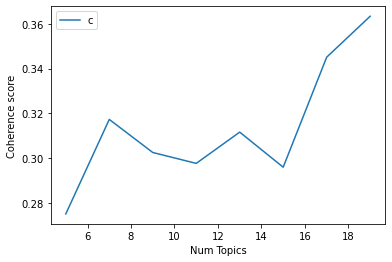

In [73]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

# plot the coherence values when number of topics equals to different numbers
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [74]:
#plot the coherence values when number of topics equals to different numbers
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.275
Num Topics = 7  has Coherence Value of 0.3173
Num Topics = 9  has Coherence Value of 0.3025
Num Topics = 11  has Coherence Value of 0.2976
Num Topics = 13  has Coherence Value of 0.3116
Num Topics = 15  has Coherence Value of 0.2959
Num Topics = 17  has Coherence Value of 0.3451
Num Topics = 19  has Coherence Value of 0.3634


# LDA Mallet - Topics and Keywords

In [76]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus,
                                             num_topics=20,
                                             id2word=id2word)

# Show Topics
model_topics = ldamallet.show_topics(formatted=False)
pprint(sorted(ldamallet.print_topics(num_words=6)))

[(0,
  '0.109*"detail" + 0.103*"asset" + 0.053*"late" + 0.046*"family" + '
  '0.043*"call" + 0.031*"give"'),
 (1,
  '0.077*"work" + 0.069*"company" + 0.035*"time" + 0.031*"wait" + '
  '0.030*"world" + 0.023*"millionaire"'),
 (2,
  '0.076*"market" + 0.074*"make" + 0.054*"level" + 0.051*"bank" + 0.047*"week" '
  '+ 0.046*"pay"'),
 (3,
  '0.129*"investment" + 0.059*"offer" + 0.055*"plan" + 0.055*"strategy" + '
  '0.053*"planning" + 0.053*"advice"'),
 (4,
  '0.087*"private" + 0.040*"day" + 0.040*"manage" + 0.036*"head" + '
  '0.035*"event" + 0.029*"talk"'),
 (5,
  '0.102*"learn" + 0.071*"digital" + 0.053*"customer" + 0.046*"time" + '
  '0.043*"experience" + 0.040*"high"'),
 (6,
  '0.056*"find" + 0.054*"make" + 0.048*"money" + 0.041*"free" + '
  '0.040*"training" + 0.034*"online"'),
 (7,
  '0.090*"read" + 0.071*"future" + 0.070*"gain" + 0.043*"daily" + '
  '0.031*"launch" + 0.028*"build"'),
 (8,
  '0.119*"business" + 0.088*"manager" + 0.053*"personal" + 0.047*"finance" + '
  '0.044*"check" 

In [77]:
import gensim    
gensim_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)


#Visualizing topics
# Saliency: a measure of how much the term tells you about the topic.
# Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.
# The size of the bubble measures the importance of the topics, relative to the data

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(gensim_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [86]:
tweets_copy2['subjectivity'] = tweets_copy2.text.map(lambda text: TextBlob(text).sentiment.subjectivity)

In [80]:
#matching indices between lda model and visualization
def translateLdaIdx(myLdaModel, myLdaViz):
    """Translate lda model topics to match the topics in pyLDAvis visualization"""
    ldaVizIdx = myLdaViz[0].index
    return list(ldaVizIdx)

newIdx = translateLdaIdx(gensim_model,lda_display)

In [81]:
def createDenseMat(myLdaModel,myCorpus,newIdx):
    """Transform corpus to dataframe with topics matching lda visualization"""
    numTopics = myLdaModel.num_topics
    myDense = corpus2dense(myLdaModel[myCorpus],numTopics)
    myDf = pd.DataFrame(myDense)
    mySortedDf = myDf.transpose()
    mySortedDf = myDf.transpose()[newIdx]
    mySortedDf.columns = ['topic' + str(i + 1) for i in range(numTopics)]
    return mySortedDf

In [82]:
from gensim.matutils import corpus2csc, sparse2full, corpus2dense

topics = createDenseMat(gensim_model,corpus,newIdx)

In [83]:
def sortByTopicToIdx(mySortedDf,myTopic,myTopicThresh=0.1):
    """Returns an index of tweets surpassing a topic value threshold"""
    srtIdx = list(mySortedDf[mySortedDf[myTopic]>myTopicThresh].index)
    return srtIdx

In [84]:
sortedIdx = sortByTopicToIdx(topics,'topic19',myTopicThresh=0.1)

In [85]:
# '0.089*"firm" + 0.060*"invest" + 0.043*"roboadvisor" + 0.043*"fund" + '
#   '0.042*"grow" + 0.042*"start"'),

def sortTweetsByIdx(tweets,srtIdx):
    """Returns sorted tweets as a list based on a defined sort index"""
    df=tweets.iloc[sortedIdx]
    return df

In [92]:
topicdf=pd.DataFrame(sortTweetsByIdx(tweets_copy2,sortedIdx),columns=tweets_copy2.columns)

In [93]:
topicdf.shape

(131, 14)

In [94]:
topicdf.sort_values(by=['subjectivity'], ascending=False,inplace= True)

In [95]:
topicdf.to_csv('robo_advisors.csv')